In [ ]:
# Install library tambahan jika diperlukan
!pip install scikit-fuzzy pandas scikit-learn matplotlib numpy
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
from google.colab import files

# Upload file CSV
uploaded = files.upload()  # Pilih file CSV

# Membaca data dari file CSV
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

Saving exported_columns_sungaibatanghari2.csv to exported_columns_sungaibatanghari2.csv


In [ ]:
# Pastikan kolom target tersedia
target_columns = ['TSS', 'pH', 'EC', 'TDS', 'CHLA']
data = data[target_columns]

# Mengisi nilai NaN dengan median
data = data.fillna(data.median())

# Standarisasi data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# PCA untuk menurunkan dimensi menjadi 2 komponen utama
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)
data[['PCA1', 'PCA2']] = pca_result  # Menyimpan hasil PCA dalam dua kolom

# Fungsi untuk menghitung WL Index
def calculate_wl_index(u, cntr, data_points):
    numerator = 0
    denominator = 0
    num_clusters = len(cntr)

    for i in range(num_clusters):
        cluster_distances = np.linalg.norm(data_points - cntr[i], axis=1)**2
        weighted_distances = np.sum((u[i] ** 2) * cluster_distances)
        sum_membership = np.sum(u[i])
        numerator += weighted_distances / sum_membership if sum_membership != 0 else 0

    inter_cluster_distances = [np.linalg.norm(cntr[i] - cntr[j])**2 for i in range(num_clusters) for j in range(i + 1, num_clusters)]
    if inter_cluster_distances:
        min_distance = np.min(inter_cluster_distances)
        median_distance = np.median(inter_cluster_distances)
        denominator = min_distance + median_distance

    return numerator / denominator if denominator != 0 else float('inf')

# Fungsi untuk menghitung Fuzzy Silhouette Index
def calculate_fsi(u, cntr, data_points, alpha=1):
    """
    Menghitung Fuzzy Silhouette Index (FSI) berdasarkan rumus teoretis.

    Parameters:
    - u: matriks partisi fuzzy (shape: [n_cluster, n_data])
    - cntr: array centroid (shape: [n_cluster, n_features])
    - data_points: array data asli (shape: [n_data, n_features])
    - alpha: parameter kontrol bobot (default = 1)

    Returns:
    - FSI (float)
    """
    n_data = data_points.shape[0]
    n_cluster = cntr.shape[0]
    silhouette_scores = []
    weights = []

    for j in range(n_data):
        # Hitung keanggotaan tertinggi dan kedua tertinggi
        membership = u[:, j]
        sorted_indices = np.argsort(membership)[::-1]  # descending
        p = sorted_indices[0]
        q = sorted_indices[1]

        # Hitung a(i): jarak ke centroid klaster sendiri
        a = np.linalg.norm(data_points[j] - cntr[p])

        # Hitung b(i): jarak ke centroid klaster tetangga
        b = np.linalg.norm(data_points[j] - cntr[q])

        # Silhouette untuk titik j
        if max(a, b) != 0:
            s_j = (b - a) / max(a, b)
        else:
            s_j = 0

        # Bobot berdasarkan beda keanggotaan
        weight = (membership[p] - membership[q]) ** alpha

        silhouette_scores.append(s_j * weight)
        weights.append(weight)

    fsi = np.sum(silhouette_scores) / np.sum(weights)
    return fsi

# Fuzzy C-Means
for n_clusters in [2, 3, 4, 5]:
    # Fuzzy C-Means clustering
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        data[['PCA1', 'PCA2']].T, n_clusters, 2, error=0.005, maxiter=1000, init=None
    )
    cluster_labels = np.argmax(u, axis=0)  # Klasterisasi berbasis derajat keanggotaan

    # Simpan hasil klasterisasi
    data[f'Cluster_{n_clusters}'] = cluster_labels

    # Hitung jumlah data per klaster
    print(f"Jumlah data per klaster untuk {n_clusters} klaster:")
    for i in range(n_clusters):
        cluster_size = np.sum(cluster_labels == i)
        print(f"  Cluster {i+1}: {cluster_size}")

    # Evaluasi Fuzzy C-Means
    # Partition Coefficient (PC)
    pc = np.mean(np.sum(u**2, axis=0))
    # Partition Entropy (PE)
    pe = -np.mean(np.sum(u * np.log(u), axis=0))
    # Xie-Beni Index (XB)
    min_dist = np.min([np.linalg.norm(cntr[i] - cntr[j]) for i in range(len(cntr)) for j in range(i + 1, len(cntr))])
    distances = np.linalg.norm(data[['PCA1', 'PCA2']].values - cntr[:, None], axis=2)**2
    xb = np.sum(u * distances) / (len(data) * min_dist**2)
    # WL Index (menggantikan MDI)
    wl_index = calculate_wl_index(u, cntr, data[['PCA1', 'PCA2']].values)
    # Fuzzy Silhouette Index (FSI)
    fsi = calculate_fsi(u, cntr, data[['PCA1', 'PCA2']].values, alpha=1)

    # Output evaluasi
    print(f"Evaluasi untuk {n_clusters} Klaster:")
    print(f"  Partition Coefficient (PC): {pc:.4f}")
    print(f"  Partition Entropy (PE): {pe:.4f}")
    print(f"  Xie-Beni Index (XB): {xb:.4f}")
    print(f"  WL Index: {wl_index:.4f}")
    print(f"  Fuzzy Silhouette Index (FSI): {fsi:.4f}")
    print("-" * 50)


Jumlah data per klaster untuk 2 klaster:
  Cluster 1: 81245
  Cluster 2: 48517
Evaluasi untuk 2 Klaster:
  Partition Coefficient (PC): 0.8447
  Partition Entropy (PE): 0.2637
  Xie-Beni Index (XB): 0.1464
  WL Index: 0.0755
  Fuzzy Silhouette Index (FSI): 0.7644
--------------------------------------------------
Jumlah data per klaster untuk 3 klaster:
  Cluster 1: 54776
  Cluster 2: 43375
  Cluster 3: 31611
Evaluasi untuk 3 Klaster:
  Partition Coefficient (PC): 0.7537
  Partition Entropy (PE): 0.4462
  Xie-Beni Index (XB): 0.3258
  WL Index: 0.1242
  Fuzzy Silhouette Index (FSI): 0.7181
--------------------------------------------------
Jumlah data per klaster untuk 4 klaster:
  Cluster 1: 21852
  Cluster 2: 40296
  Cluster 3: 38451
  Cluster 4: 29163
Evaluasi untuk 4 Klaster:
  Partition Coefficient (PC): 0.6947
  Partition Entropy (PE): 0.5778
  Xie-Beni Index (XB): 0.5450
  WL Index: 0.1183
  Fuzzy Silhouette Index (FSI): 0.6907
--------------------------------------------------
J

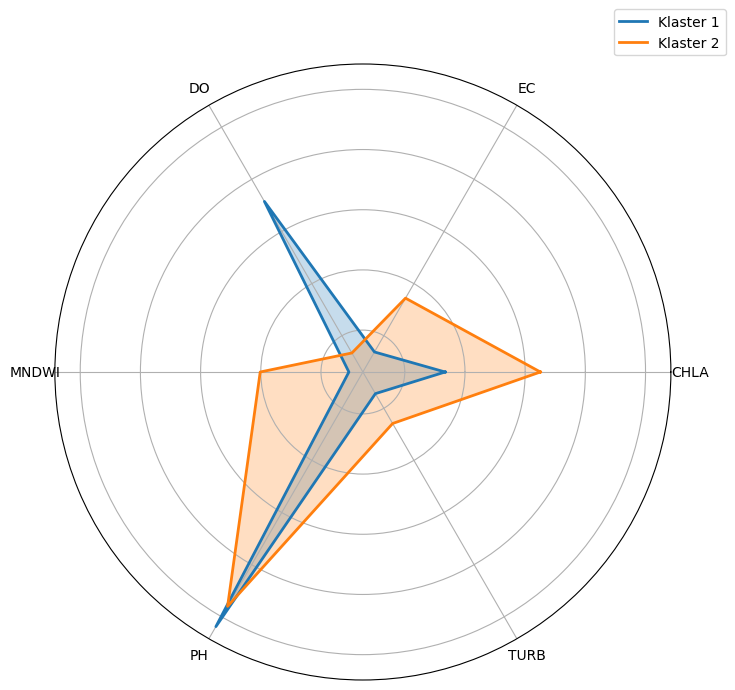

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ubah nama kolom ke versi lebih pendek
short_names = {
    'CHLA': 'CHLA',
    'EC': 'EC',
    'DO': 'DO',
    'MNDWI': 'MNDWI',
    'PH': 'PH',
    'TUR': 'TURB'
}

# Ambil target kolom dengan nama baru
target_cols = list(short_names.values())

# Simpan hasil FCM ke DataFrame
df_scaled = pd.DataFrame(scaled_data, columns=short_names.keys()).rename(columns=short_names)
df_scaled['Cluster'] = cluster_labels  # Tambahkan label klaster dari FCM

# Ambil hanya klaster 0 dan 1
cluster_means = df_scaled.groupby('Cluster').mean().loc[[0, 1]]

# Radar Chart
angles = np.linspace(0, 2 * np.pi, len(target_cols), endpoint=False).tolist()
angles += angles[:1]  # Tutup lingkaran radar plot

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot hanya klaster 0 dan 1
for cluster in [0, 1]:
    values = cluster_means.loc[cluster].tolist()
    values += values[:1]  # Tutup lingkaran radar plot
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=f'Klaster {cluster + 1}')
    ax.fill(angles, values, alpha=0.25)

# Konfigurasi tampilan radar chart tanpa angka
ax.set_xticks(angles[:-1])
ax.set_xticklabels(target_cols, fontsize=10)
ax.set_yticklabels([])  # Hapus angka di sumbu
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

plt.show()


In [ ]:
# Simpan hasil ke CSV
output_file = 'hasil_fcm_pca_revisi1.csv'
data.to_csv(output_file, index=False)
print(f"Hasil klasterisasi disimpan di {output_file}.")
# Memberikan link untuk mengunduh file CSV
files.download(output_file)

Hasil klasterisasi disimpan di hasil_fcm_pca_revisi1.csv.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Menampilkan eigenvector dan explained variance
print("Eigenvector (Komponen Utama):")
print(pca.components_)

print("\nExplained Variance:")
print(pca.explained_variance_ratio_)

# Menampilkan total variance yang dijelaskan oleh komponen pertama
print("\nTotal Explained Variance by the First Component:")
print(np.sum(pca.explained_variance_ratio_))

Eigenvector (Komponen Utama):
[[ 0.41858534  0.45188416  0.46033541  0.46033541  0.44358724]
 [ 0.85382178 -0.12335586 -0.09221854 -0.09221854 -0.48863399]]

Explained Variance:
[0.90592773 0.0544084 ]

Total Explained Variance by the First Component:
0.9603361311456162
